## Data Preparation

In [3]:
import numpy as np
import json

# Chargement des données à partir du fichier JSON
with open('donnees_clusterisees.json', 'r') as f:
    data = json.load(f)
    
# On evite d'importer les données mal etiquete
data = [d for d in data if d['label'] not in [0]]
labels = [d['label'] for d in data]

# Extraction de la colonne "name" et "description"
names = [d['name'] for d in data]

# # Application de la fonction preprocess sur les noms et descriptions de monuments
# clean_names = [preprocess(name) for name in names]

## Learning

### Train different models
---
Let's start by splitting the data into a training sample and a test sample (80/20)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, Y_train, Y_test = train_test_split(names, labels, test_size=0.7, random_state=42)

# Fit and transform the CountVectorizer on your training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
# Transform your test data using the same CountVectorizer object
X_test = vectorizer.transform(X_test)

#### K-nearest neighbors

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def trainWithKNNClassifier(neighbors_range):
    # Store the scores
    cv_scores = []
    
    # Loop over the hyperparameter values
    for k in neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=3)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter with the highest score
    best_k = neighbors_range[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)
  
    # Calculate 95% confidence interval for the best score
    std_error = np.std(cv_scores) / np.sqrt(3)
    lower_bound = best_score - 1.96 * std_error
    upper_bound = best_score + 1.96 * std_error
    
    return cv_scores, best_k, best_score, lower_bound, upper_bound

#### Decision trees (max_depth)

In [6]:
from sklearn.tree import DecisionTreeClassifier

def trainWithDecisionTreeClassifier(depth_range):

    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []

    # Loop over the hyperparameter values and compute the cross-validation score for each
    for depth in depth_range:
        dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
        scores = cross_val_score(dt, X_train, Y_train, cv=10)
        cv_scores.append(np.mean(scores))

    # Find the best hyperparameter value with the highest cross-validation score
    best_depth = depth_range[np.argmax(cv_scores)]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval for the best score
    std_error = np.std(cv_scores) / np.sqrt(10)
    lower_bound = best_score - 1.96 * std_error
    upper_bound = best_score + 1.96 * std_error

    return cv_scores, best_depth, best_score, lower_bound, upper_bound

#### Perceptron linéaire

In [7]:
from sklearn.linear_model import Perceptron

def trainWithPerceptron(max_iters):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []

    # Loop over the hyperparameter values and compute the cross-validation score for each
    for max_iter in max_iters:
        perceptron = Perceptron(max_iter=max_iter)
        scores = cross_val_score(perceptron, X_train, Y_train, cv=10)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter value with the highest cross-validation score
    best_max_iter = max_iters[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    std_err = np.std(cv_scores) / np.sqrt(10)
    lower_bound = best_score - 1.96 * std_err
    upper_bound = best_score + 1.96 * std_err

    return cv_scores, best_max_iter, best_score, lower_bound, upper_bound

#### SVC Gaussian

In [8]:
from sklearn.svm import SVC

def trainWithSVCGaussian(gammas):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []

    # Loop over the hyperparameter values and compute the cross-validation score for each
    for gamma in gammas:
        svm = SVC(kernel='rbf', gamma=gamma)
        scores = cross_val_score(svm, X_train, Y_train, cv=10)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter value with the highest cross-validation score
    best_gamma = gammas[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    std_err = np.std(cv_scores) / np.sqrt(10)
    lower_bound = best_score - 1.96 * std_err
    upper_bound = best_score + 1.96 * std_err

    return cv_scores, best_gamma, best_score, lower_bound, upper_bound

#### SVC Polynomial

In [9]:
from sklearn.svm import SVC

def trainWithSVCPolynomial(degrees):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []

    # Loop over the hyperparameter values and compute the cross-validation score for each
    for degree in degrees:
        svm = SVC(kernel='poly', degree=degree)
        scores = cross_val_score(svm, X_train, Y_train, cv=10)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter value with the highest cross-validation score
    best_degree = degrees[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    std_err = np.std(cv_scores) / np.sqrt(10)
    lower_bound = best_score - 1.96 * std_err
    upper_bound = best_score + 1.96 * std_err
    
    return cv_scores, best_degree, best_score, lower_bound, upper_bound

---
Let's first define a generic function to plot the scores of each algorithms with the best hyperparameter

In [10]:
import matplotlib.pyplot as plt

def plot_hyperparameter(hyperparam_range, cv_scores, best_hyperparam, best_score, lower_bound, upper_bound, title, xlabel, label):
    # Plot the cross-validation scores as a function of the hyperparameter values
    plt.plot(hyperparam_range, cv_scores)
    plt.xlabel(xlabel)
    plt.ylabel('Cross-validation score')
    plt.title(title)

    # Highlight the best hyperparameter value and its corresponding cross-validation score
    plt.axvline(x=best_hyperparam, color='r', linestyle='--', label=label % (best_hyperparam, best_score, lower_bound, upper_bound))
    plt.legend()

    plt.show()

---
### Results analysis
We will display on a curve the scores of each of the algorithms with the best possible hyperparameter value on the test sample.

In [11]:
# Lets define a list to store the results for each classifier
results = []

# Lets define some constant to make the code more readable
CLASSIFIER = "Classifier"
HYPERPARAMETER = "Hyperparameter"
BEST_HYPERPARAMETER = "Best Hyperparameter"
BEST_SCORE = "Best Score"
LOWER_BOUND = "Lower Bound"
UPPER_BOUND = "Upper Bound"

#### K-nearest neighbors

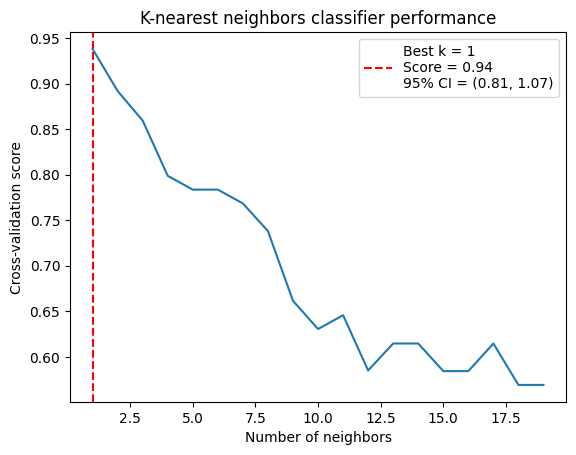

In [12]:
neighbors_range = range(1, 20)
cv_scores, best_k, best_score, lower_bound, upper_bound = trainWithKNNClassifier(neighbors_range)

label='Best k = %d\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(neighbors_range, cv_scores, best_k, best_score, lower_bound, upper_bound, 'K-nearest neighbors classifier performance', 'Number of neighbors', label)

results.append({
    CLASSIFIER: 'K-nearest neighbors',
    HYPERPARAMETER: 'Number of neighbors',
    BEST_HYPERPARAMETER: best_k,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### Decision trees (max_depth)

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Lo

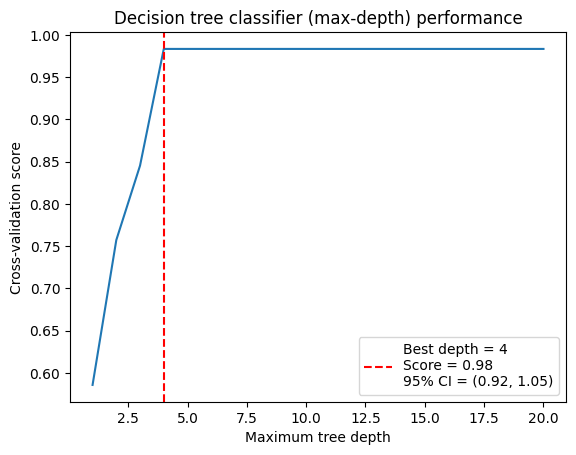

In [13]:
depth_range = range(1, 21)
cv_scores, best_depth, best_score, lower_bound, upper_bound = trainWithDecisionTreeClassifier(depth_range)

label='Best depth = %d\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(depth_range, cv_scores, best_depth, best_score, lower_bound, upper_bound, 'Decision tree classifier (max-depth) performance', 'Maximum tree depth', label)

results.append({
    CLASSIFIER: 'Decision tree',
    HYPERPARAMETER: 'Maximum tree depth',
    BEST_HYPERPARAMETER: best_depth,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### Perceptron

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Administrat

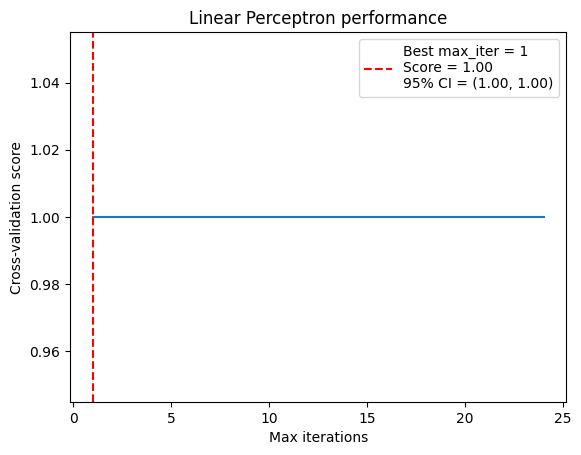

In [14]:
# Define the range of values for the hyperparameter to tune
max_iters = range(1, 25)
cv_scores, best_max_iter, best_score, lower_bound, upper_bound = trainWithPerceptron(max_iters)

label='Best max_iter = %d\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(max_iters, cv_scores, best_max_iter, best_score, lower_bound, upper_bound, 'Linear Perceptron performance', 'Max iterations', label)

results.append({
    CLASSIFIER: 'Linear perceptron',
    HYPERPARAMETER: 'Max iterations',
    BEST_HYPERPARAMETER: best_max_iter,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### SVC Gaussian

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Lo

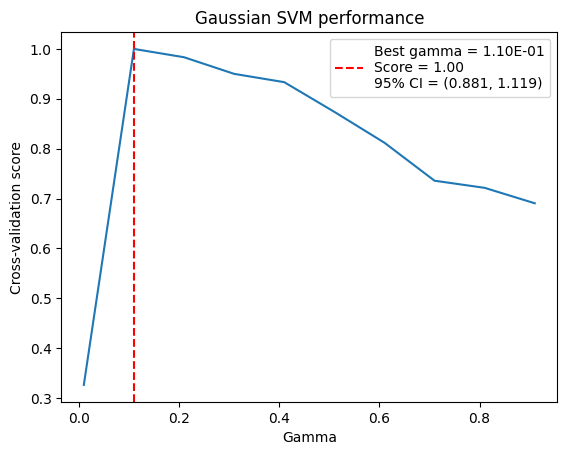

In [15]:
# Define the range of values for the hyperparameter to tune
gammas = np.arange(0.01, 1, 0.1)
cv_scores, best_gamma, best_score, lower_bound, upper_bound = trainWithSVCGaussian(gammas)

label='Best gamma = %0.2E\nScore = %0.2f\n95%% CI = (%0.3f, %0.3f)'
plot_hyperparameter(gammas, cv_scores, best_gamma, best_score, lower_bound, upper_bound, 'Gaussian SVM performance', 'Gamma', label)

results.append({
    CLASSIFIER: 'Gaussian SVM',
    HYPERPARAMETER: 'Gamma',
    BEST_HYPERPARAMETER: best_gamma,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### SVC Polynomial

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Lo

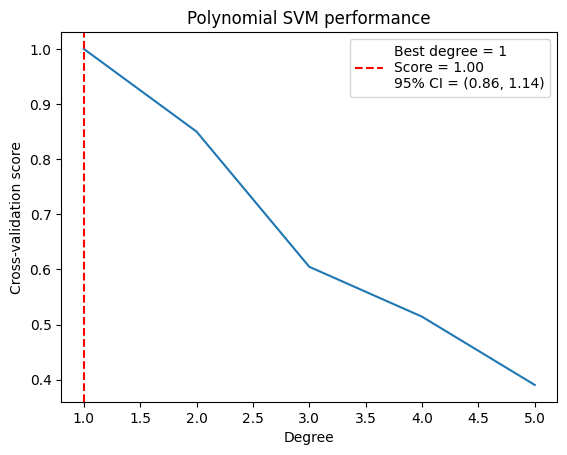

In [16]:
# Define the range of values for the hyperparameter to tune
degrees = range(1, 6)
cv_scores, best_degree, best_score, lower_bound, upper_bound = trainWithSVCPolynomial(degrees)

label='Best degree = %d\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(degrees, cv_scores, best_degree, best_score, lower_bound, upper_bound, 'Polynomial SVM performance', 'Degree', label)

results.append({
    CLASSIFIER: 'Polynomial SVM',
    HYPERPARAMETER: 'Degree',
    BEST_HYPERPARAMETER: best_degree,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

---
### Overview
---

In [24]:
import pandas as pd
df = pd.DataFrame(results)

df_sorted = df.sort_values(by=BEST_SCORE, ascending=False)
df_sorted.head()

,Classifier,Hyperparameter,Best Hyperparameter,Best Score,Lower Bound,Upper Bound
2,Linear perceptron,Max iterations,1.00,1.000000,1.000000,1.000000
3,Gaussian SVM,Gamma,0.11,1.000000,0.881391,1.118609
4,Polynomial SVM,Degree,1.00,1.000000,0.861985,1.138015
1,Decision tree,Maximum tree depth,4.00,0.983333,0.921460,1.045207
0,K-nearest neighbors,Number of neighbors,1.00,0.937951,0.807230,1.068672


## Classification

#### K-nearest neighbors

In [55]:
def classifyWithKNeighborsClassifier():
    best_hyperparam = df.loc[df[CLASSIFIER] == 'K-nearest neighbors', BEST_HYPERPARAMETER].iloc[0]

    knn = KNeighborsClassifier(n_neighbors=int(best_hyperparam))
    knn.fit(X_train, Y_train)

    Y_pred = knn.predict(X_test)
    return X_test, Y_pred

#### Decision trees (max_depth)

In [56]:
def classifyWithDecisionTreeClassifier():
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Decision tree', BEST_HYPERPARAMETER].iloc[0]

    dt = DecisionTreeClassifier(max_depth=int(best_hyperparam), random_state=42)
    dt.fit(X_train, Y_train)

    Y_pred = dt.predict(X_test)
    return X_test, Y_pred

#### Perceptron

In [57]:
def classifyWithPerceptron():
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Linear perceptron', BEST_HYPERPARAMETER].iloc[0]

    perceptron = Perceptron(max_iter=int(best_hyperparam))
    perceptron.fit(X_train, Y_train)

    Y_pred = perceptron.predict(X_test)
    return X_test, Y_pred

#### SVC Gaussian

In [58]:
def classifyWithSVCGaussian():
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Gaussian SVM', BEST_HYPERPARAMETER].iloc[0]

    svm = SVC(kernel='rbf', gamma=best_hyperparam)
    svm.fit(X_train, Y_train)

    Y_pred = svm.predict(X_test)
    return X_test, Y_pred

#### SVC Polynomial

In [59]:
def classifyWithSVCPolynomial():    
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Polynomial SVM', BEST_HYPERPARAMETER].iloc[0]

    svm = SVC(kernel='poly', degree=int(best_hyperparam))
    svm.fit(X_train, Y_train)

    Y_pred = svm.predict(X_test)
    return X_test, Y_pred

### Classification results

Let's write a function to display the predicted labels of the monuments tests set and display them with their name and categories.

In [61]:
import plotly.graph_objects as go

def show_monuments_by_label(Y_pred, X_test):
    # Création de la figure
    fig = go.Figure()

    # Ajout des points sur la figure avec les noms des monuments et les prédictions en survolant les points
    fig.add_trace(go.Scatter(x=Y_pred, y=list(range(X_test.shape[0])),
                        mode='markers',
                        text=[names[i] + '<br>Prediction: ' + str(Y_pred[i]) for i in range(X_test.shape[0])],
                        hovertemplate='%{text}',
                        marker=dict(
                            size=10,
                            color=Y_pred,
                            colorscale='Viridis',
                            line_width=0.5)))

    # Configuration des marges et des titres de la figure
    fig.update_layout(title='Monument Classification',
                    xaxis_title='Predicted Label',
                    yaxis_title='Monument',
                    margin=dict(l=50, r=50, t=50, b=50))

    fig.update_layout(height=800)

    # Affichage de la figure
    fig.show()

#### K-nearest neighbors

In [ ]:
X_test, Y_pred = classifyWithKNeighborsClassifier()
show_monuments_by_label(Y_pred, X_test)

#### Decision trees (max_depth)

In [ ]:
X_test, Y_pred = classifyWithDecisionTreeClassifier()
show_monuments_by_label(Y_pred, X_test)

#### Perceptron

In [ ]:
X_test, Y_pred = classifyWithPerceptron()
show_monuments_by_label(Y_pred, X_test)

#### SVC Gaussian

In [ ]:
X_test, Y_pred = classifyWithSVCGaussian()
show_monuments_by_label(Y_pred, X_test)

#### SVC Polynomial

In [ ]:
X_test, Y_pred = classifyWithSVCPolynomial()
show_monuments_by_label(Y_pred, X_test)